# U-net

An attempt to get a quick grasp of U-net like architectures. 
The code is adapted from a great [keras](https://keras.io/examples/vision/oxford_pets_image_segmentation/) tutorial

In [3]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz


Downloads/cursor-0.42.4-build-2410291z3bdg1dy-x86_64.AppImage: This does not look like a tar archive

gzip: stdin: not in gzip format
Downloads/cursor-0.42.4-build-2410291z3bdg1dy-x86_64.AppImage: Child returned status 1
Downloads/cursor-0.42.4-build-2410291z3bdg1dy-x86_64.AppImage: Error is not recoverable: exiting now
Downloads/cursor-0.42.4-build-2410291z3bdg1dy-x86_64.AppImage: This does not look like a tar archive

gzip: stdin: not in gzip format
Downloads/cursor-0.42.4-build-2410291z3bdg1dy-x86_64.AppImage: Child returned status 1
Downloads/cursor-0.42.4-build-2410291z3bdg1dy-x86_64.AppImage: Error is not recoverable: exiting now


In [3]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


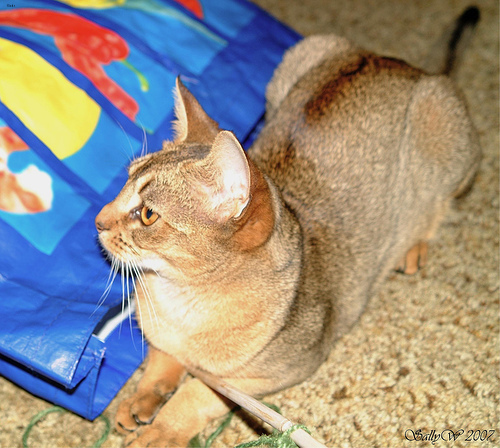

In [4]:
from IPython.display import Image, display
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))


In [37]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import numpy as np


class OxfordPetsDataset(Dataset):
    def __init__(
        self,
        img_size: tuple[int, int],
        input_img_paths: list[str],
        target_img_paths: list[str],
    ):
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
            
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor()
        ])
        self.target_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self) -> int:
        return len(self.input_img_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        input_img = Image.open(self.input_img_paths[idx]).convert("RGB")
        target_img = Image.open(self.target_img_paths[idx]).convert("L")
        
        input_img = self.transform(input_img)
        target_img = self.target_transform(target_img)
        
        target_img = (target_img * 255).long() - 1
        
        return input_img, target_img.squeeze(0)

    def get_paths(self, index: int) -> tuple[str, str]:
        return self.input_img_paths[index], self.target_img_paths[index]


dataset = OxfordPetsDataset(img_size, input_img_paths, target_img_paths)


In [38]:
train_size = 0.7
val_size = 0.15
batch_size = 32

n_samples = len(dataset)
train_size_int = int(n_samples * train_size)
val_size_int = int(n_samples * val_size)
test_size_int = n_samples - train_size_int - val_size_int

indices = torch.randperm(n_samples).tolist()
train_indices = indices[:train_size_int]
val_indices = indices[train_size_int:train_size_int + val_size_int] 
test_indices = indices[train_size_int + val_size_int:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Train size: 5173
Validation size: 1108
Test size: 1109


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.conv2(F.relu(self.conv1(x))))


class TransposedConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.conv2(F.relu(self.conv1(x))))


class UNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.inc = ConvBlock(3, 64)
        self.down1 = ConvBlock(64, 128)
        self.down2 = ConvBlock(128, 256)
        self.up1 = TransposedConvBlock(256, 128)
        self.up2 = TransposedConvBlock(128, 64)
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3) + x2
        x = self.up2(x) + x1
        return self.outc(x)


In [8]:
from torch.optim import Adam
from tqdm import tqdm

def train(model: nn.Module,
         train_loader: DataLoader,
         val_loader: DataLoader,
         num_epochs: int = 10,
         learning_rate: float = 1e-3,
         device: str = "cuda" if torch.cuda.is_available() else "cpu") -> nn.Module:

    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                
        val_loss /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

    model.to("cpu")
        
    return model


In [9]:
model = train(UNet(num_classes), train_loader, val_loader, num_epochs=10, learning_rate=1e-3)


100%|█████████████████████████████████████████████| 162/162 [00:48<00:00,  3.32it/s]


Epoch 1/10
Train Loss: 0.8806
Val Loss: 0.8144


100%|█████████████████████████████████████████████| 162/162 [00:47<00:00,  3.44it/s]


Epoch 2/10
Train Loss: 0.7622
Val Loss: 0.7307


100%|█████████████████████████████████████████████| 162/162 [00:47<00:00,  3.44it/s]


Epoch 3/10
Train Loss: 0.6900
Val Loss: 0.6694


100%|█████████████████████████████████████████████| 162/162 [00:47<00:00,  3.40it/s]


Epoch 4/10
Train Loss: 0.6490
Val Loss: 0.6317


100%|█████████████████████████████████████████████| 162/162 [01:18<00:00,  2.07it/s]


Epoch 5/10
Train Loss: 0.6061
Val Loss: 0.5754


100%|█████████████████████████████████████████████| 162/162 [00:46<00:00,  3.45it/s]


Epoch 6/10
Train Loss: 0.5932
Val Loss: 0.6126


100%|█████████████████████████████████████████████| 162/162 [00:47<00:00,  3.44it/s]


Epoch 7/10
Train Loss: 0.5763
Val Loss: 0.5659


100%|█████████████████████████████████████████████| 162/162 [00:47<00:00,  3.44it/s]


Epoch 8/10
Train Loss: 0.5734
Val Loss: 0.5785


100%|█████████████████████████████████████████████| 162/162 [00:46<00:00,  3.45it/s]


Epoch 9/10
Train Loss: 0.5592
Val Loss: 0.5538


100%|█████████████████████████████████████████████| 162/162 [00:46<00:00,  3.45it/s]


Epoch 10/10
Train Loss: 0.5505
Val Loss: 0.5501


In [57]:
test_preds = []
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()

for images, masks in tqdm(test_loader):
    images = images.to(device)
    masks = masks.to(device)
    with torch.no_grad():
        outputs = model(images)
        outputs = outputs.to("cpu")
    test_preds.append(outputs)


100%|███████████████████████████████████████████████| 35/35 [00:08<00:00,  4.21it/s]


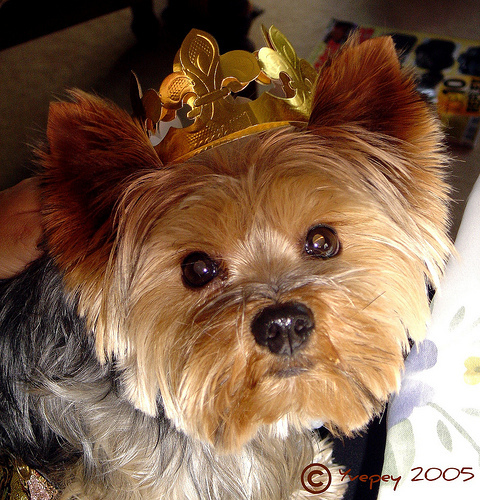

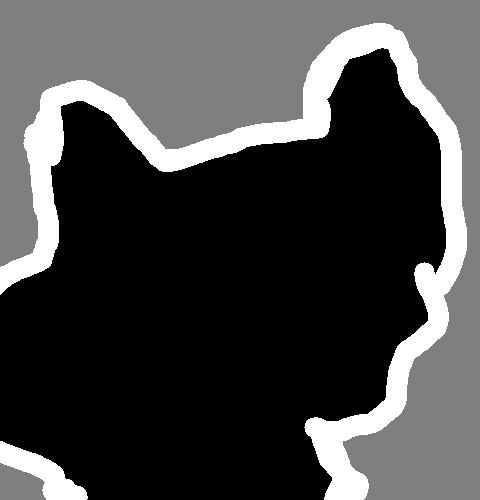

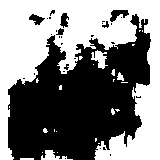

In [58]:


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = torch.argmax(test_preds[i // batch_size][i % batch_size], dim=0)
    mask = mask.cpu().numpy()
    img = Image.fromarray((mask * 255).astype(np.uint8))
    img = ImageOps.autocontrast(img)
    display(img)


# Display results for image #10
i = 10

# Display input image
display(Image.open(input_img_paths[test_indices[i]]))

# Display ground-truth target mask
img = Image.open(target_img_paths[test_indices[i]])
img = ImageOps.autocontrast(img)
display(img)

display_mask(i)